In [2]:
import numpy as np
import math
from dataset import load_data
from sklearn.model_selection import train_test_split
from detectors.gradient_boosting_classifier import GradientBoostingClassifier
from sklearn import tree
from utilities.metrics import classification_metrics
import matplotlib.pyplot as plt
from experiments.experiments import DEFAULT_PARAMS
from manager import MethodManager
from sklearn.ensemble import GradientBoostingClassifier as skGBC

In [3]:
random_state = 0
n_explain = 20
test_size = 0.2
dataset = "vertebral"

params = DEFAULT_PARAMS
params["GradientBoostingClassifier"]["gbc_ntrees"] = 1
params["GradientBoostingClassifier"]["gbc_maxdepth"] = 2

In [4]:
x,y, ds_info = load_data(dataset_name=dataset, normalize_numeric=True, normalize_discrete=True)
indices = np.arange(start=0, stop=x.shape[0])
xtrain, xtest, ytrain, ytest, idx_train, idx_test = train_test_split(
    x, y, indices, test_size=test_size, shuffle=True, random_state=random_state)
if n_explain is not None:
    x_explain = xtest[:n_explain]
    y_explain = ytest[:n_explain]
    idx_explain = idx_test[:n_explain]
else:
    x_explain = xtest
    y_explain = ytest
    idx_explain = idx_test
    n_explain = x_explain.shape[0]

In [22]:
lr = 0.7
n_trees = 100
sk_gbc = skGBC(n_estimators=n_trees, max_depth=1, learning_rate=lr, loss="log_loss", init=None, random_state=0)
sk_gbc.fit(xtrain, ytrain)
instance = np.zeros(shape=(1,6))
sk_gbc.predict_proba(instance)

array([[0.04925137, 0.95074863]])

In [21]:
sk_gbc.init_.predict_proba([xtrain[0]])
sk_gbc.init_.predict_proba([xtrain[1]])[0, 1]

AttributeError: 'str' object has no attribute 'predict_proba'

In [99]:
def sigmoid(z):
    '''
    Logistic function
    '''
    return 1/(1 + np.exp(-z))

# log-odds = SUM[ f[i] + lr*f[i-1] + lr*f[i-2] ... ]
# prob(Y = 1) = sigmoid(logodds)
pred_nodes = [int(_) for _ in sk_gbc.apply(instance).squeeze()]
# pred_nodes.reverse()
log_odds = 0
tree_id = len(pred_nodes) - 1
# while tree_id >= 0:
for tree_id in range(len(pred_nodes)):
    node_id = pred_nodes[tree_id]
    tree_i = sk_gbc.estimators_[tree_id][0]
    pred_val = tree_i.tree_.value[node_id, 0][0]
    log_odds += lr * pred_val
    tree_id = tree_id - 1 
print(sigmoid(log_odds))

0.8394316358390569


In [68]:
sk_gbc.estimators_[0,0].tree_.value[0, 0][0]

0.17611336032388664

In [56]:
sk_gbc.estimators_[0][0]

DecisionTreeRegressor(criterion='friedman_mse', max_depth=1,
                      random_state=RandomState(MT19937) at 0x1C98B9BC540)

In [41]:

pred_node_id = int(sk_gbc.apply(instance).squeeze())
print("node: {}".format(pred_node_id))
val = sk_gbc.estimators_[0,0].tree_.value[pred_node_id].squeeze()
val = val * lr
print("val {}".format(val))
prob = 1/(1+ np.exp(-val))
print("prob {}".format(prob))
print("1-prob {}".format(1-prob))
print("sigval {}".format(sigmoid(val)))

sk_gbc.predict_proba(instance)

node: 1
val -0.3528455284552845
prob 0.4126925583426789
1-prob 0.5873074416573212
sigval 0.4126925583426789


array([[0.58730744, 0.41269256]])

In [5]:
sk_gbc.loss_

In [6]:
# train the gradient boosting classifier
manager = MethodManager(explainer="FACETIndex", hyperparameters=params, random_state=random_state)
gbc = GradientBoostingClassifier(hyperparameters=params, random_state=random_state)
manager.model = gbc
manager.train(xtrain, ytrain)

In [7]:
# check the classification accuracy
preds = manager.predict(xtest)
accuracy, precision, recall, f1 = classification_metrics(preds, ytest, verbose=False)
print("f1: {}".format(f1))
print("accuracy: {}".format(accuracy))
print("precision: {}".format(precision))
print("recall: {}".format(accuracy))

f1: 0.8076923076923077
accuracy: 0.6774193548387096
precision: 0.6774193548387096
recall: 0.6774193548387096


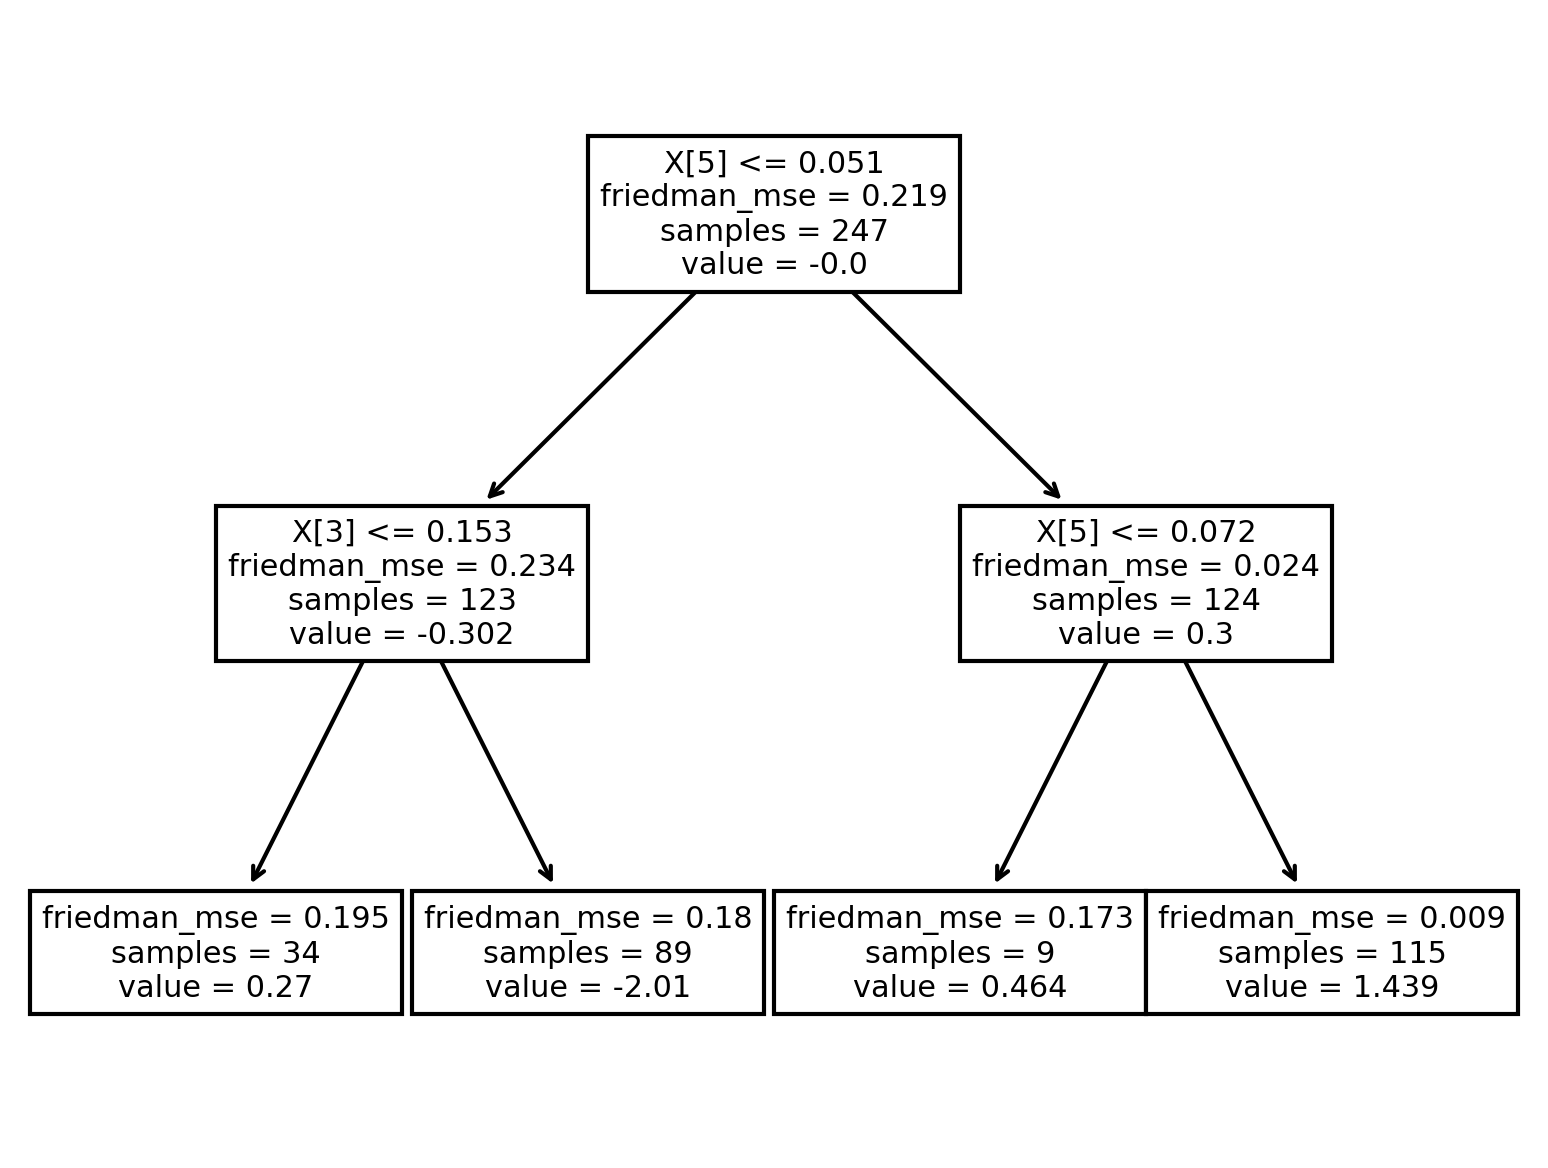

In [8]:
plt.figure(dpi=300)
t = manager.model.model.estimators_[0][0]
tree.plot_tree(t)
plt.savefig("tmp.png")
plt.show()

In [9]:
# scikit tree nodes are numbered from root to leaf, from left to right. i.e. root is 0,
# its left child is 1, who's left child is 2. Assuming node 2 is a leaf, node 1's right child is 3, etc
print(t.decision_path([[0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1]]))

  (0, 0)	1
  (0, 1)	1
  (0, 2)	1
  (1, 0)	1
  (1, 4)	1
  (1, 6)	1


In [10]:
val = t.tree_.value[2][0][0]
np.exp(-1 * val)


0.7631875980253996

In [11]:
manager.model.model.predict_proba([[1, 1, 1, 1, 1, 1]])

array([[0.29319841, 0.70680159]])

In [12]:
t.predict([[0, 0, 0, 0, 0, 0]])[0]

0.27025140894681204

In [13]:
manager.model.model.predict_proba([[0, 0, 0, 0, 0, 0]])

array([[0.31799695, 0.68200305]])

In [14]:
def sigmoid(z):
    return 1/(1 + np.exp(-z))
instance = np.zeros(shape=(1,6))
pred_node_id = int(manager.model.apply(instance).squeeze())
print("node: {}".format(pred_node_id))
val = manager.model.model.estimators_[0,0].tree_.value[pred_node_id].squeeze()
print("val {}".format(val))
prob = 1/(1+ np.exp(-val))
print("prob {}".format(prob))
print("1-prob {}".format(1-prob))
print("sigval {}".format(sigmoid(val)))

gbc.model.predict_proba(instance)

node: 2
val 0.27025140894681204
prob 0.567154624453974
1-prob 0.432845375546026
sigval 0.567154624453974


array([[0.31799695, 0.68200305]])

In [15]:
type(manager.model.model)

sklearn.ensemble._gb.GradientBoostingClassifier

In [16]:
gbc

In [17]:
nnodes = t.tree_.node_count
for n in range(nnodes):
    val = t.tree_.value[n][0][0]
    print(1 / (1 + np.exp(-val)))
    

0.5
0.425036962476789
0.567154624453974
0.1181568376008958
0.5743674887127466
0.6140230519393021
0.8083513191126488


In [18]:
t.tree_.value[2][0][0]

0.27025140894681204